In [ ]:
import csv
import pandas as pd
import io
import networkx as nx
import matplotlib.pylab as plt
import numpy as np
import os
import pickle
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Finding Missing Edges in the training dataset

Code Explaination: \\
We have created a dictionary with pair of nodes as key and fixed value. If an edge between this pair exits, then value is 1, else the value is -1. 

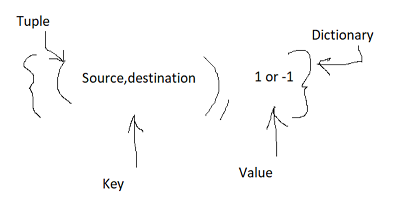

We then run a while loop to select exactly 9437519 number of missing edges and add them to missingEdges. We then randomly select two nodes from the data and check if an edge between them is present in the dictionary or not. Now, we check if the shortest path between two nodes is greater than two and if yes, we add them to our missing set. This is done to avoid overfitting and make our model learn better. 
We then finally save this output in a pickle file.



In [ ]:
r = csv.reader(open('/content/drive/MyDrive/Colab Notebooks/Facebook/train_cleaned.csv','r'))
g = nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/Facebook/train_cleaned.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)

edges = dict()
for e in r:
    edges[(e[0], e[1])] = 1
    
missingEdges = set([])

while ( len(missingEdges) < 9437519):
    u = random.randint(1, 1862220)
    v = random.randint(1, 1862220)
    temp = edges.get((u,v), -1)
    if temp == -1 and u != v:
        try:
            if nx.shortest_path_length( g , source = u, target = v ) > 2: 
                missingEdges.add((u,v))
            else:
                continue  
        except:  
                missingEdges.add((u,v))              
    else:
        continue
pickle.dump(missingEdges, open('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/missingEdges.p', 'wb'))


In [ ]:
# Uncomment this line if missingEdges.p is already created
#missingEdges = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/missingEdges.p','rb'))

### 2. Splitting Training dataset into train and validation. 
We are splitting the dataset in 80-20 split ratio.
We have kept train set of with and withOut edges seperately to create graph and features later.

In [ ]:
from sklearn.model_selection import train_test_split

g_withEdges = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/train.csv')
g_withOutEdges = pd.DataFrame(list(missingEdges), columns=['source_node', 'destination_node'])

X_train_withEdge, X_vali_withEdge, y_train_withEdge, y_vali_withEdge  = train_test_split(g_withEdges, np.ones(len(g_withEdges)), test_size=0.2, random_state=9)
X_train_withOutEdge, X_vali_withOutEdge, y_train_withOutEdge, y_vali_withOutEdge  = train_test_split(g_withOutEdges, np.zeros(len(g_withOutEdges)), test_size=0.2, random_state=9)

#removing header and saving
X_train_withEdge.to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/train_withEdge.csv',header=False, index=False)
X_vali_withEdge.to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/vali_withEdge.csv',header=False, index=False)
X_train_withOutEdge.to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/train_withOutEdge.csv',header=False, index=False)
X_vali_withOutEdge.to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/vali_withOutEdge.csv',header=False, index=False)


Analyzing our splitted dataset

In [ ]:
g_train = nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/train_withEdge.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype = int)
g_vali = nx.read_edgelist('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/vali_withEdge.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype = int)

print("Our Training graph contains ",nx.info(g_train))
print("Our Validation graph contains ",nx.info(g_vali))

g_train_nodes = set(g_train.nodes())
g_vali_nodes = set(g_vali.nodes())

intersection = len(g_train_nodes.intersection(g_vali_nodes))
train_notVali = len(g_train_nodes - g_vali_nodes)
vali_notTrain = len(g_vali_nodes - g_train_nodes)

print('Common nodes in train and validation set: ',intersection)
print('Number of users present in train but not present in validation: ',train_notVali)

print('Number of users present in validation but not present in train: ',vali_notTrain)

Our Training graph contains  DiGraph with 1780722 nodes and 7550015 edges
Our Validation graph contains  DiGraph with 1144623 nodes and 1887504 edges
Common nodes in train and validation set:  1063125
Number of users present in train but not present in validation:  717597
Number of users present in validation but not present in train:  81498


In [ ]:
#Joining our X and y values and saving to file
X_train = X_train_withEdge.append(X_train_withOutEdge,ignore_index=True)
y_train = np.concatenate((y_train_withEdge,y_train_withOutEdge))
X_test = X_vali_withEdge.append(X_vali_withOutEdge,ignore_index=True)
y_test = np.concatenate((y_vali_withEdge,y_vali_withOutEdge)) 

X_train.to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/train_final.csv', header=False, index=False)
X_test.to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/analyzed_data/test_final.csv', header=False, index=False)
pd.DataFrame(y_train.astype(int)).to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/train_y.csv', header=False, index=False)
pd.DataFrame(y_test.astype(int)).to_csv('/content/drive/MyDrive/Colab Notebooks/Facebook/test_y.csv', header=False, index=False)

In [ ]:
# References

# https://realpython.com/train-test-split-python-data/